Reference: https://excelsior-cjh.tistory.com/109

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup as bs
from urllib.parse import urlparse
from urllib.parse import parse_qs
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import plotly.offline as offline
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Korea Exchange: https://kind.krx.co.kr/corpgeneral/corpList.do?method=loadInitPage

In [2]:
raw_data = pd.read_html('상장법인목록.xls', converters={'종목코드':str})[0]
stocks_data = raw_data.iloc[:, :2].copy()
stocks_data.rename(columns={'회사명':'name', '종목코드': 'code'}, inplace=True)

,name,code
2494,CJ대한통운,000120
2495,메리츠화재,000060
2496,경방,000050
2497,유수홀딩스,000700
2498,한진중공업홀딩스,003480


NAVER Finance: https://finance.naver.com/

In [3]:
def find_stock_page_url(stock_name, stock_data):
    stock_code = stock_data.loc[stock_data['name'] == f'{stock_name}']['code'].to_string(index=False)
    url = f'https://finance.naver.com/item/sise.naver?code={stock_code}'
    return url

In [4]:
options = Options()
options.add_argument('--headless')
path = './chromedriver_win32/chromedriver'
service = Service(path)
driver = webdriver.Chrome(service=service, options=options)

In [5]:
stock_name = '삼성전자'
naver_finance_url = 'https://finance.naver.com'
stock_page_url = find_stock_page_url(stock_name, stocks_data)

response = requests.get(stock_page_url)
stock_page_soup = bs(response.content, 'html.parser')
iframe_src = stock_page_soup.select('iframe[title="일별 시세"]')[0].attrs['src']
iframe_src_url = naver_finance_url + iframe_src
print('iframe src URL:', iframe_src_url)

iframe src URL: https://finance.naver.com/item/sise_day.naver?code=005930


In [6]:
driver.get(iframe_src_url)
iframe_src_html = driver.page_source
sise_page_soup = bs(iframe_src_html, 'html.parser')

last_page_url = sise_page_soup.select('table.Nnavi a')[-1]['href']
parsed_url = urlparse(last_page_url)
last_page_num = int(parse_qs(parsed_url.query)['page'][0])
print('Last page number:', last_page_num)

Last page number: 653


In [7]:
sise_data = pd.DataFrame()
pages_to_load = 15

def get_sise_data(data, num):
    sise_page_url = iframe_src_url + f'&page={num}'
    driver.get(sise_page_url)
    sise_page_html = driver.page_source
    sise_page_data = pd.read_html(sise_page_html, header=0)[0]
    sise_page_data.dropna(inplace=True)
    concatenated_data = pd.concat([data, sise_page_data])
    return concatenated_data

if pages_to_load < last_page_num:
    for page_num in range(1, pages_to_load+1):
        sise_data = get_sise_data(sise_data, page_num)
else:
    for num in range(1, last_page_num+1):
        sise_data = get_sise_data(sise_data, page_num)

sise_data.rename(columns={'날짜':'date', '종가':'closing price', '전일비':'change', '시가':'opening price', '고가':'highest', '저가':'lowest', '거래량':'volume'}, inplace=True)
sise_data[['closing price', 'change', 'opening price', 'highest', 'lowest', 'volume']] = sise_data[['closing price', 'change', 'opening price', 'highest', 'lowest', 'volume']].apply(pd.to_numeric)
sise_data['date'] = pd.to_datetime(sise_data['date'])
sise_data = sise_data.sort_values(by='date', ascending=True, ignore_index=True)
sise_data.head()

,date,closing price,change,opening price,highest,lowest,volume
0,2021-11-12,70600.0,700.0,70200.0,70900.0,69900.0,10087450.0
1,2021-11-15,71400.0,800.0,71700.0,71900.0,70900.0,12420710.0
2,2021-11-16,71300.0,100.0,71500.0,72000.0,71300.0,10919239.0
3,2021-11-17,70700.0,600.0,71300.0,71600.0,70600.0,11027606.0
4,2021-11-18,70200.0,500.0,70700.0,71000.0,70200.0,10144957.0


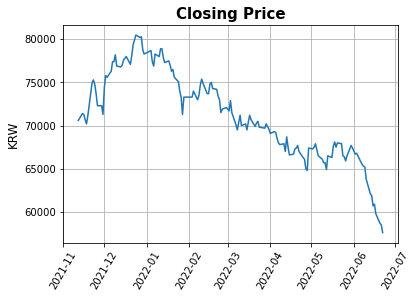

In [8]:
plt.figure()
plt.title('Closing Price', fontdict={'fontweight':'bold', 'fontsize':15})
plt.plot(sise_data['date'], sise_data['closing price'])
plt.xticks(rotation='60')
plt.ylabel('KRW', fontsize=12)
plt.grid()
plt.show()